<a href="https://colab.research.google.com/github/CenturionXV3/PortfolioOpt/blob/main/VitaHRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Portfolio Optimization using Hierarchical Risk Parity
Enter stock tickers separated by space (e.g., AAPL MSFT AMZN): 
No tickers provided. Using default tickers: AAPL, MSFT, AMZN, GOOGL, META
Use custom date range? (y/n): n


[*********************100%***********************]  5 of 5 completed


Add weight constraints? (y/n): n

Running Hierarchical Risk Parity optimization...

Optimization Results

Optimal Portfolio Weights:
AAPL: 0.3317 (33.17%)
AMZN: 0.1062 (10.62%)
GOOGL: 0.2302 (23.02%)
META: 0.1321 (13.21%)
MSFT: 0.1997 (19.97%)

Portfolio Performance Metrics:
Expected Annual Return: 9.86%
Annual Volatility: 27.70%
Sharpe Ratio: 0.36

Show portfolio visualizations? (y/n): y


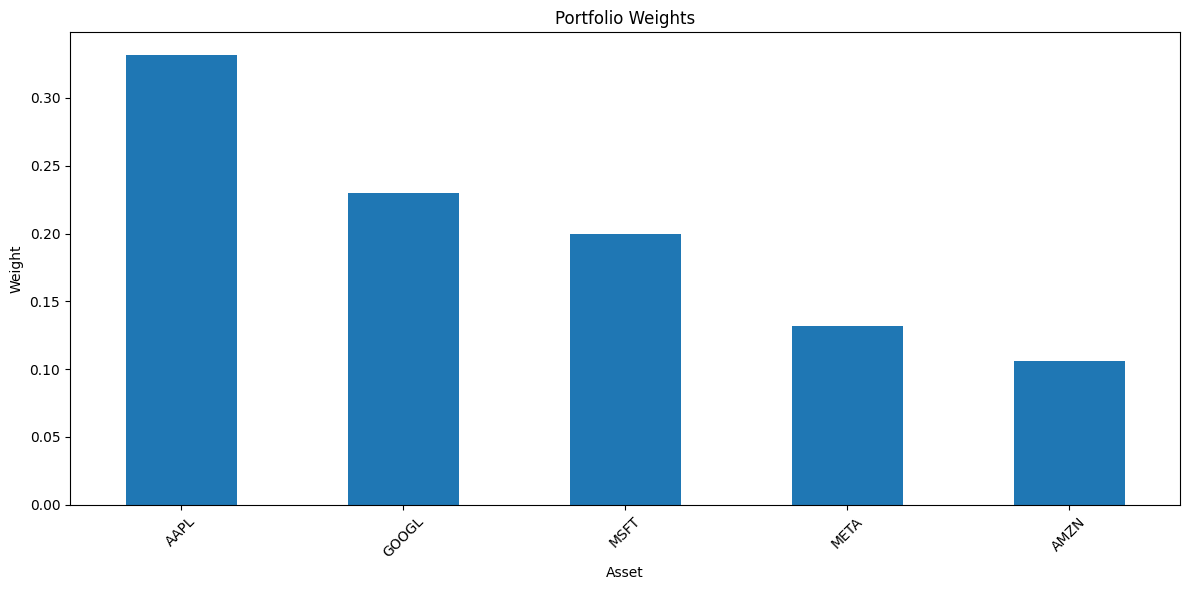

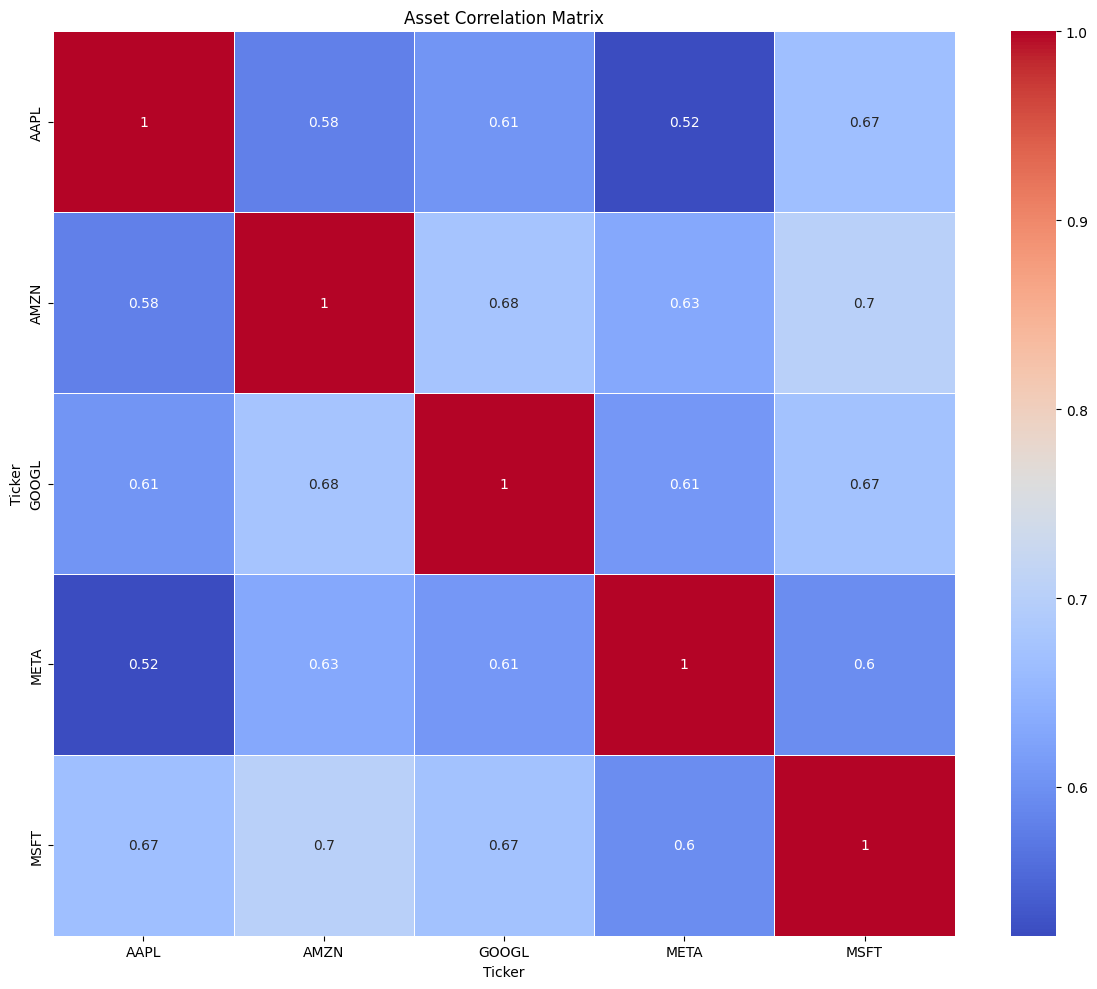

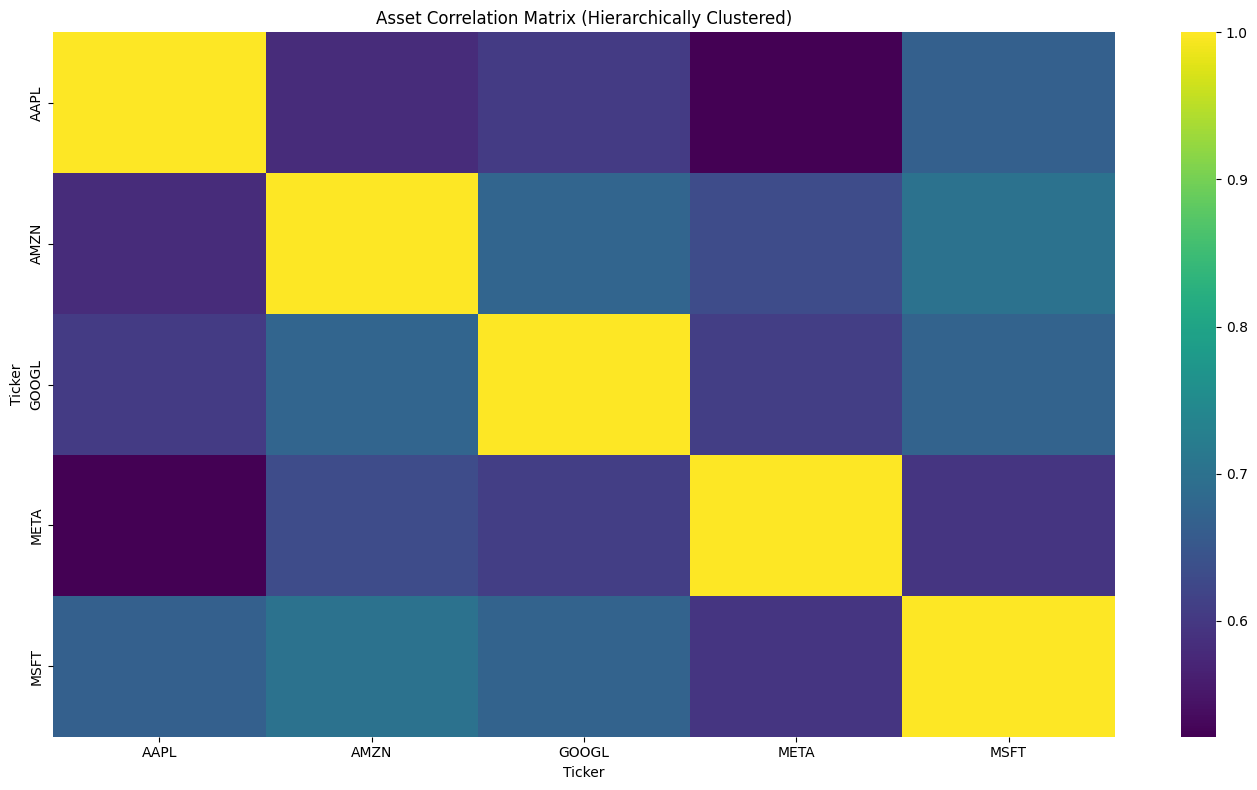

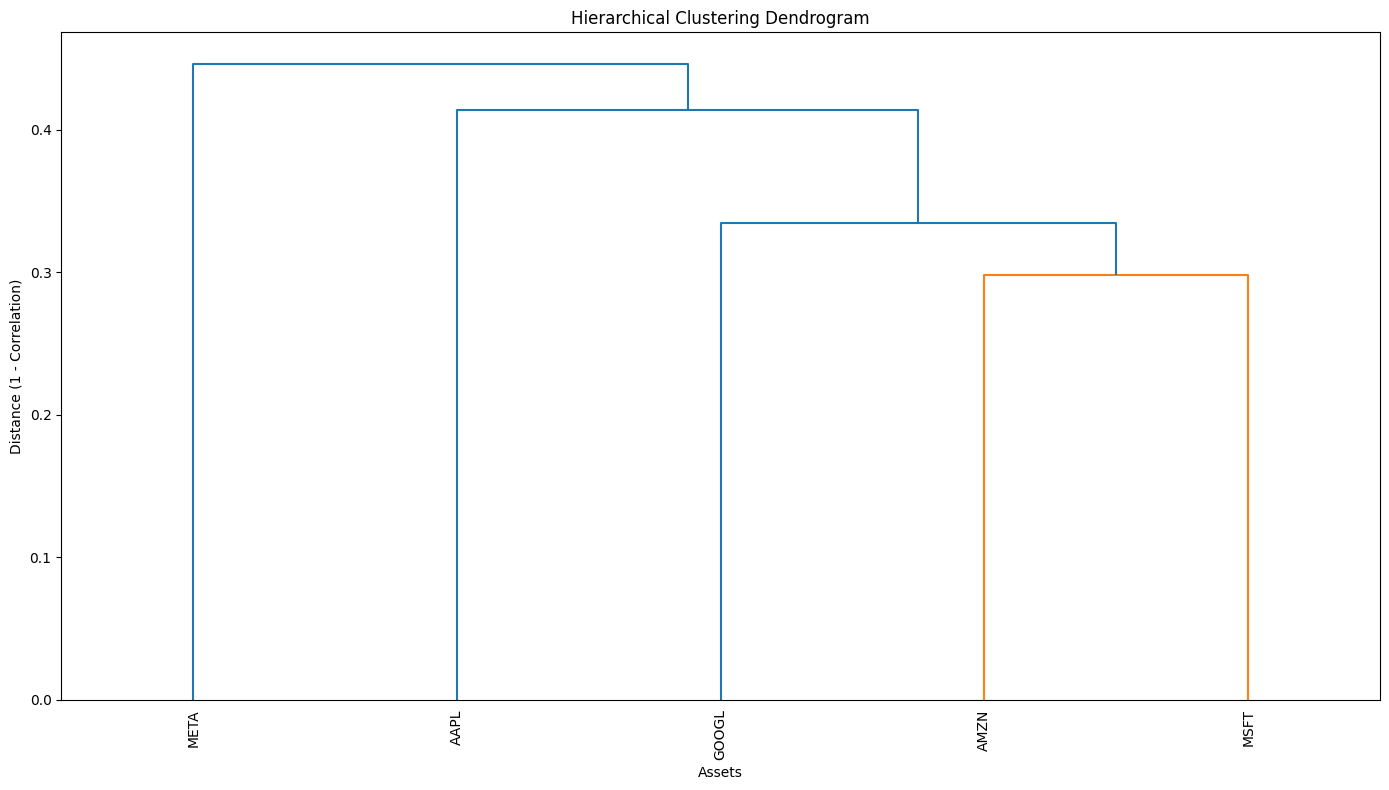


Optimization complete!


In [ ]:
!pip install pandas numpy yfinance matplotlib seaborn
!pip install PyPortfolioOpt


import sys
import subprocess
import importlib

required_packages = ['pandas', 'numpy', 'yfinance', 'matplotlib', 'seaborn', 'pypfopt']

missing_packages = []
for package in required_packages:
    try:
        importlib.import_module(package)
    except ImportError:
        missing_packages.append(package)

if missing_packages:
    print(f"The following required packages are missing: {', '.join(missing_packages)}")
    install = input("Would you like to install them now? (y/n): ").lower()
    if install == 'y':
        for package in missing_packages:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print("All required packages have been installed.")
    else:
        print("Required packages not installed. Please install them manually and run this script again.")
        sys.exit(1)

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

try:
    from pypfopt.hierarchical_portfolio import HRPOpt
    from pypfopt import risk_models, expected_returns
    from pypfopt.efficient_frontier import EfficientFrontier
except ImportError as e:
    print(f"Failed to import PyPortfolioOpt modules: {str(e)}")
    print("Please ensure the package is installed correctly.")
    print("Try running: pip install PyPortfolioOpt")
    sys.exit(1)

def get_stock_data(tickers, start_date, end_date):
    print(f"Downloading data for {len(tickers)} assets...")
    try:
        data = yf.download(tickers, start=start_date, end=end_date)['Close']
        if len(tickers) == 1:
            data = pd.DataFrame(data, columns=tickers)
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

def optimize_portfolio_hrp(prices, weight_bounds=None):
    """
    Optimize a portfolio using Hierarchical Risk Parity

    Args:
        prices (pd.DataFrame): Dataframe of asset prices
        weight_bounds (tuple, optional): Min and max weight for each asset

    Returns:
        dict: Dictionary with weights and performance metrics
    """
    # Calculate returns and covariance
    returns = expected_returns.returns_from_prices(prices)
    mean_returns = expected_returns.mean_historical_return(prices)
    cov_matrix = risk_models.sample_cov(prices)

    # Create HRP optimizer using the updated class name
    hrp = HRPOpt(returns)
    hrp_weights = hrp.optimize()

    # If constraints provided, apply them with EfficientFrontier
    if weight_bounds is not None:
        ef = EfficientFrontier(mean_returns, cov_matrix, weight_bounds=weight_bounds)
        try:
            ef.add_constraint(lambda w: w >= weight_bounds[0])  # Min weight constraint
            ef.add_constraint(lambda w: w <= weight_bounds[1])  # Max weight constraint
            # Use HRP weights as a prior
            ef_weights = ef.min_volatility()
            ef_weights = ef.clean_weights()
            weights = ef_weights
        except Exception as e:
            print(f"Could not apply constraints properly: {e}")
            print("Falling back to unconstrained HRP solution.")
            weights = hrp_weights
    else:
        weights = hrp_weights

    # Performance metrics
    portfolio_return = sum(mean_returns * pd.Series(weights))
    portfolio_volatility = np.sqrt(pd.Series(weights).dot(cov_matrix.dot(pd.Series(weights))))
    sharpe_ratio = portfolio_return / portfolio_volatility

    # Get clusters information
    try:
        clusters = hrp.clusters
        ordered_indices = hrp.ordered_indices
    except AttributeError:
        clusters = [list(prices.columns)]
        ordered_indices = list(range(len(prices.columns)))

    return {
        "weights": weights,
        "expected_annual_return": portfolio_return,
        "annual_volatility": portfolio_volatility,
        "sharpe_ratio": sharpe_ratio,
        "clusters": clusters,
        "ordered_indices": ordered_indices
    }

def plot_portfolio_weights(weights):
    plt.figure(figsize=(12, 6))
    ax = pd.Series(weights).sort_values(ascending=False).plot(kind='bar')
    plt.title('Portfolio Weights')
    plt.ylabel('Weight')
    plt.xlabel('Asset')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(prices):
    plt.figure(figsize=(12, 10))
    correlation = prices.pct_change().corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Asset Correlation Matrix')
    plt.tight_layout()
    plt.show()

def plot_hierarchical_clusters(prices, result):
    plt.figure(figsize=(14, 8))

    # This is a simplified visualization of clusters
    cov = risk_models.sample_cov(prices)
    corr = risk_models.cov_to_corr(cov)

    try:
        # If we have ordered indices, use them to reorder the correlation matrix
        if "ordered_indices" in result and result["ordered_indices"]:
            tickers = prices.columns
            ordered_tickers = [tickers[i] for i in result["ordered_indices"]]
            ordered_corr = corr.loc[ordered_tickers, ordered_tickers]
        else:
            # If no ordered indices or clusters available, just use original correlation
            ordered_corr = corr
    except Exception as e:
        print(f"Error in cluster visualization: {e}")
        ordered_corr = corr

    sns.heatmap(ordered_corr, cmap='viridis', annot=False)
    plt.title('Asset Correlation Matrix (Hierarchically Clustered)')
    plt.tight_layout()
    plt.show()

    # Try to plot a basic dendrogram if scipy is available
    try:
        from scipy.cluster import hierarchy
        import scipy.spatial.distance as ssd

        plt.figure(figsize=(14, 8))

        # Make sure correlation matrix is symmetric
        corr_matrix = corr.fillna(0)  # Fill any NaN values

        # Create a condensed distance matrix (upper triangular only)
        # Convert correlation to distance: closer correlation = smaller distance
        distance = np.zeros((len(corr_matrix) * (len(corr_matrix) - 1)) // 2)
        k = 0
        for i in range(len(corr_matrix) - 1):
            for j in range(i + 1, len(corr_matrix)):
                distance[k] = 1 - corr_matrix.iloc[i, j]
                k += 1

        # Perform hierarchical clustering
        linkage = hierarchy.linkage(distance, 'ward')

        # Create dendrogram
        hierarchy.dendrogram(
            linkage,
            labels=corr_matrix.index,
            leaf_rotation=90,
            leaf_font_size=10
        )
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('Assets')
        plt.ylabel('Distance (1 - Correlation)')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("SciPy not available for dendrogram visualization.")
    except Exception as e:
        print(f"Error creating dendrogram: {e}")
        # Print more detailed error information for debugging
        import traceback
        traceback.print_exc()

def main():
    print("=" * 50)
    print("Portfolio Optimization using Hierarchical Risk Parity")
    print("=" * 50)

    # Get user input for tickers
    ticker_input = input("Enter stock tickers separated by space (e.g., AAPL MSFT AMZN): ")
    tickers = ticker_input.upper().split()

    if not tickers:
        print("No tickers provided. Using default tickers: AAPL, MSFT, AMZN, GOOGL, META")
        tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META']

    # Date range for historical data
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*3)  # 3 years of data

    # User input for custom date range
    custom_dates = input("Use custom date range? (y/n): ").lower()
    if custom_dates == 'y':
        try:
            start_date = input("Enter start date (YYYY-MM-DD): ")
            end_date = input("Enter end date (YYYY-MM-DD): ")
            start_date = datetime.strptime(start_date, "%Y-%m-%d")
            end_date = datetime.strptime(end_date, "%Y-%m-%d")
        except ValueError:
            print("Invalid date format. Using default: 3 years of data.")
            end_date = datetime.now()
            start_date = end_date - timedelta(days=365*3)

    # Download data
    prices = get_stock_data(tickers, start_date, end_date)

    if prices is None or prices.empty:
        print("No data available for the selected tickers and date range.")
        return

    # Check for missing data
    missing_columns = [ticker for ticker in tickers if ticker not in prices.columns]
    if missing_columns:
        print(f"Warning: No data found for these tickers: {missing_columns}")
        # Remove missing tickers
        tickers = [ticker for ticker in tickers if ticker not in missing_columns]

    # Handle NaN values
    if prices.isna().any().any():
        print("Warning: Missing values detected. Filling with forward fill method.")
        prices = prices.ffill().dropna()

    if prices.empty or prices.shape[0] < 252:  # At least one year of data
        print("Not enough data after handling missing values.")
        return

    # Weight constraints option
    constraints_option = input("Add weight constraints? (y/n): ").lower()

    weight_bounds = None
    if constraints_option == 'y':
        try:
            min_weight = float(input("Enter minimum weight for each asset (e.g., 0.05): "))
            max_weight = float(input("Enter maximum weight for each asset (e.g., 0.30): "))

            if min_weight < 0 or max_weight > 1 or min_weight > max_weight:
                print("Invalid weight bounds. Using unconstrained optimization.")
            else:
                weight_bounds = (min_weight, max_weight)
                print(f"Using weight bounds: {weight_bounds}")
        except ValueError:
            print("Invalid input. Using unconstrained optimization.")

    # Run optimization
    print("\nRunning Hierarchical Risk Parity optimization...")
    result = optimize_portfolio_hrp(prices, weight_bounds)

    # Display results
    print("\n" + "=" * 50)
    print("Optimization Results")
    print("=" * 50)
    print("\nOptimal Portfolio Weights:")
    for ticker, weight in result["weights"].items():
        print(f"{ticker}: {weight:.4f} ({weight*100:.2f}%)")

    print("\nPortfolio Performance Metrics:")
    print(f"Expected Annual Return: {result['expected_annual_return']*100:.2f}%")
    print(f"Annual Volatility: {result['annual_volatility']*100:.2f}%")
    print(f"Sharpe Ratio: {result['sharpe_ratio']:.2f}")

    # Visualization option
    viz_option = input("\nShow portfolio visualizations? (y/n): ").lower()
    if viz_option == 'y':
        plot_portfolio_weights(result["weights"])
        plot_correlation_matrix(prices)
        plot_hierarchical_clusters(prices, result)

    print("\nOptimization complete!")

if __name__ == "__main__":
    main()